In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272643 sha256=3ef89343dd39792d1b04d890e73b07a0c6dda9568f1cf11bedfb9b261d6102d2
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline
import imgaug as ia
import imgaug.augmenters as iaa

In [3]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

# Reference to Image Segmentation

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

In [4]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    print('\nNumber of COCO categories: {}'.format(len(nms)))
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [len(imgIds)]     
        
    return coco, df

In [5]:
# Load the annotations of the image dataset
coco, classes = getCOCO(train_anns_path)

# Preview a sample of the classes dataframe
classes.head()

loading annotations into memory...
Done (t=3.65s)
creating index...
index created!

Number of COCO categories: 273


,Category,Count
0,water,1835
1,pear,151
2,egg,626
3,grapes,94
4,butter,1008


# Reference for Getting Masks

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

https://github.com/virafpatrawala/COCO-Semantic-Segmentation/blob/master/COCOdataset_SemanticSegmentation_Demo.ipynb

https://github.com/qubvel/segmentation_models/issues/137

https://www.reddit.com/r/computervision/comments/ihh8n0/onehotencoding_with_multichannel_images/

In [6]:
# Function that gets images. 
# It is useful possible to get just a subset of images by setting subset to True. This option
# can be useful for example to make first attempts of training without using the whole training set
def getImgs(path, image_size, subset=False, subset_size=500):
    
    # Get image Ids
    imgIds = coco.getImgIds()
    
    if subset:
        imgIds = random.sample(imgIds, subset_size)
        
    images = coco.loadImgs(imgIds)
    
    # Get annotation Ids
    annIds = coco.getAnnIds(imgIds)
    anns = coco.loadAnns(annIds)
    
    img_lst = []
    msk_lst = []
    
    for file in images:
        # Read the image from the full file path
        img = cv2.imread(path + '/' + file['file_name'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image to the given size
        img = cv2.resize(img, image_size)
        
        # Create a zero array with the given size and number of classes
        full_mask = np.zeros((image_size[0], image_size[1], classes.shape[0] + 1))
        
        # Set the first channel to ones to represent the initial background
        full_mask[:, :, 0] = np.logical_not(full_mask[:, :, 0])
        
        for i, ann in enumerate(anns):
            # Check if the annotation belongs to the current image
            if ann['image_id'] == file['id']:
                annotation = anns.pop(i)
                
                # Get the category's name from the annotation's category Id
                category = coco.loadCats(annotation['category_id'])[0]['name']
                
                # Get the binary mask for the annotation
                mask = cv2.resize(coco.annToMask(annotation), image_size)
                
                # Get the channel index for the annotation
                index = classes[classes.Category == category].index[0] + 1
                
                # Update the channel of the annotation
                full_mask[:, :, index] = np.logical_or(full_mask[:, :, index], mask)
                
                # Update the background channel of the annotation
                full_mask[:, :, 0] = np.logical_and(full_mask[:, :, 0], np.logical_not(mask))
        
        img_lst.append(img)
        msk_lst.append(full_mask)
                
    return img_lst, msk_lst

In [7]:
# Get the images and masks from the given path
images, masks = getImgs(train_imgs_path, (224, 224), subset=True, subset_size=10)

# Check if the number of images and masks are the same
print('Number of images: {}'.format(len(images)))
print('Number of masks: {}'.format(len(masks)))

Number of images: 10
Number of masks: 10


# Reference for Model Building

https://github.com/qubvel/segmentation_models#quick-start

https://github.com/qubvel/segmentation_models/issues/374

https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb

https://github.com/qubvel/segmentation_models/issues/254

In [8]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.5 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [9]:
# Define the model to be trained
model = sm.Unet('resnet34', encoder_weights='imagenet', classes=274, activation='softmax')
model.compile('Adam', loss='categorical_crossentropy', metrics=[sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])

85524480/85521592 [==============================] - 1s 0us/step


In [10]:
# Train the defined model on the dataset
history = model.fit(x=np.array(images), y=np.array(masks), validation_split=0.1, batch_size=20, epochs=50)

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: 5.5768 - iou_score: 1.1186e-04 - precision: 0.0036 - recall: 0.9673 - val_loss: 5.5421 - val_iou_score: 2.7004e-05 - val_precision: 0.0037 - val_recall: 0.9927
Epoch 2/50
1/1 [==============================] - 1s 571ms/step - loss: 5.3954 - iou_score: 1.4657e-04 - precision: 0.0039 - recall: 0.9673 - val_loss: 6.2944 - val_iou_score: 1.3672e-05 - val_precision: 0.0036 - val_recall: 0.9927
Epoch 3/50
1/1 [==============================] - 0s 491ms/step - loss: 5.2358 - iou_score: 2.7377e-04 - precision: 0.0044 - recall: 0.9675 - val_loss: 6.4169 - val_iou_score: 1.2146e-05 - val_precision: 0.0035 - val_recall: 0.9927
Epoch 4/50
1/1 [==============================] - 1s 512ms/step - loss: 5.1072 - iou_score: 3.3957e-04 - precision: 0.0045 - recall: 0.9676 - val_loss: 6.8957 - val_iou_score: 9.8745e-06 - val_precision: 0.0033 - val_recall: 0.9927
Epoch 5/50
1/1 [==============================] - 0s 497ms/step - loss: 4

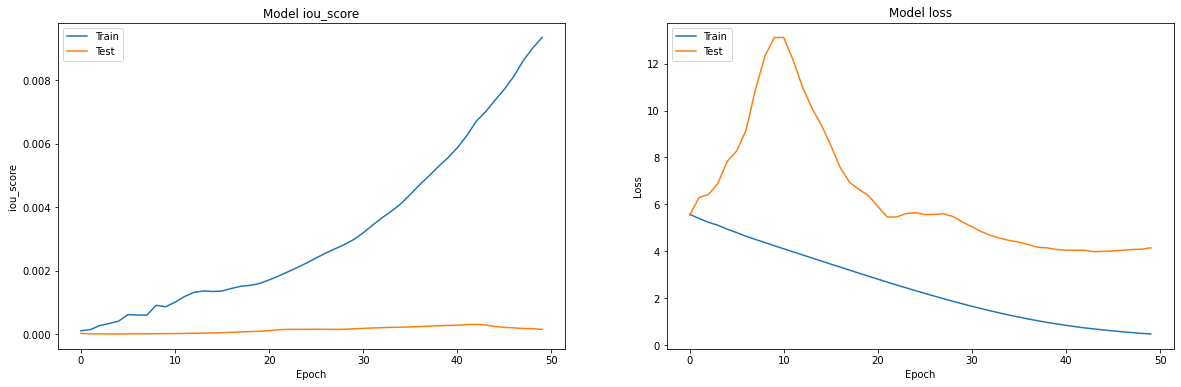

In [11]:
# Plot the loss and iou score over the epochs
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# Save the model to the output
model.save_weights('trained_model.h5')

In [13]:
# # Load the trained model weights
# weights_path = '../input/food-recognition-model/trained_model.h5'
# model.load_weights(weights_path)